# Scales Poisson distribution to plot weighted data plot

In [1]:
# you can ignore code if you don't care
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.special import gammaln
from scipy.integrate import quad
import ROOT
%matplotlib inline

Welcome to JupyROOT 6.16/00


The recipe is from

```
@book{bohm2010introduction,
  title={Introduction to statistics and data analysis for physicists},
  author={Bohm, G. and Zech, G.},
  isbn={9783935702416},
  url={http://www-library.desy.de/preparch/books/vstatmp_engl.pdf}
  year={2010},
  page={61-65}
  publisher={DESY}
}
```

Convenctions: random variables are in capital.

Let's start from the simple counting example, without weights.

## RooFit error bars

When plotting error bars with RooFit by default it assumes that the number of events in each bin is Poisson distributed. The error bar plotted is a 68% frequentist confidence level. Here nice slides to show different alternatives (intervals from likelihood ratio, Bayesian interval, and frequensist, e.g. RooFit): https://www.nikhef.nl/~ivov/Statistics/PoissonError/2017_02_24_PoissonError_LHCb_IvovanVulpen.pdf

Here what RooFit does. For one bin we observe $n_{obs}$, $\lambda$ is the true number of expected events in that bin. $n_{obs}$ is distributed as a Poisson with pdf

$$\text{Pois}(n_{obs} | \lambda)$$

the upper and lower edges of the error bar are actually the upper and lower limit excluded at $1-\alpha=68\%$

$$\text{upper limit} = \text{ArgMin}_\lambda \left[P(N \leq n_{obs}|\lambda) \geq \alpha / 2\right]$$
$$\text{lower limit} = \text{ArgMax}_\lambda \left[P(N \geq n_{obs}|\lambda) \geq \alpha / 2\right]$$

RooFit chooses to have symmetric probability.

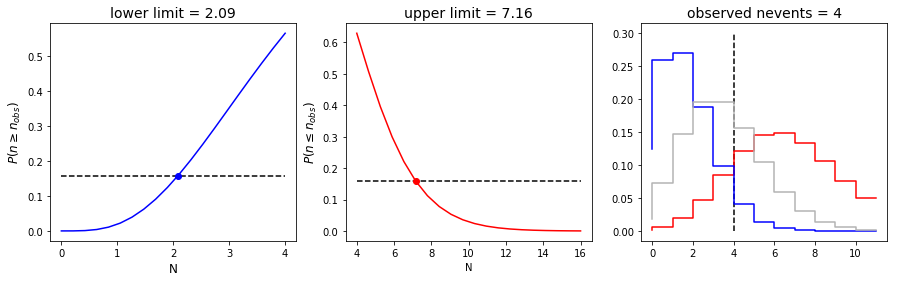

In [2]:
# example showing how to find the limits with a simple scan

def z2p(z, onetail=True):
    """ significance to pvalue """
    if onetail:
        return stats.norm.sf(z)
    else:
        return stats.norm.sf(z) * 2

NOBS = 4        # suppose we observed four events
ALPHA = z2p(1, False) # 0.317...

# this computes P(n <= nobs | lambda) or P(n >= nobs | lambda)
# lambda here is called ntrue (lambda is a keyword in python)
def compute_pvalue(nobs, ntrue, left):
    if left:
        # the left case (<=) is the cdf
        return stats.poisson(ntrue).cdf(nobs)
    else:
        # the right case is the survival function plus the last bin (because >= and not just >)
        return stats.poisson(ntrue).sf(nobs) + stats.poisson(ntrue).pmf(nobs)

# do a scan to find the limit values
    
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
x = np.linspace(NOBS, NOBS + 3 * NOBS, 20)

axs[1].plot(x, compute_pvalue(NOBS, x, left=True), 'r')
axs[1].hlines(ALPHA / 2., np.min(x), np.max(x), linestyles='--')

x = np.linspace(max(NOBS - NOBS * 3, 0), NOBS, 20)
axs[0].plot(x, compute_pvalue(NOBS, x, left=False), 'b')
axs[0].hlines(ALPHA / 2., np.min(x), np.max(x), linestyles='--')

# instead of a manual scan, let find the solution as a root-finding problem
from scipy.optimize import brenth
nup = brenth(lambda x: compute_pvalue(NOBS, x, True) - ALPHA / 2., NOBS, NOBS * 3)
ndown = brenth(lambda x: compute_pvalue(NOBS, x, False) - ALPHA / 2., 1E-5, NOBS)

# just plotting
axs[1].plot(nup, compute_pvalue(NOBS, nup, True), 'ro')
axs[0].plot(ndown, compute_pvalue(NOBS, ndown, False), 'bo')
axs[1].set_xlabel('N'); axs[0].set_xlabel('N', fontsize=12)
axs[1].set_ylabel('$P(n\leq n_{obs})$', fontsize=12)
axs[0].set_ylabel('$P(n\geq n_{obs})$', fontsize=12)

x = np.arange(0, NOBS * 3)
axs[2].plot(x, stats.poisson(nup).pmf(x), 'r', linestyle='steps',)
axs[2].plot(x, stats.poisson(ndown).pmf(x), 'b', linestyle='steps')
axs[2].plot(x, stats.poisson(NOBS).pmf(x), '0.7', linestyle='steps')
axs[2].vlines(NOBS, 0, 0.3, linestyles='--')

axs[0].set_title('lower limit = %.2f' % ndown, fontsize=14)
axs[1].set_title('upper limit = %.2f' % nup, fontsize=14)
axs[2].set_title('observed nevents = %d' % NOBS, fontsize=14)


plt.show()
fig.savefig('poisson_example.pdf')
plt.close(fig)

In [3]:
# just print the result
from IPython.display import Latex
Latex("$\lambda = %.2f^{+%.2f}_{-%.2f}$" % (NOBS, nup - NOBS, NOBS - ndown))

<IPython.core.display.Latex object>

### Check if this matches with what computed by RooFit

In [4]:
import ROOT
rootfit_ndown, roofit_nup = ROOT.double(), ROOT.double()

for nobs in range(5):
    ROOT.RooHistError.instance().getPoissonInterval(nobs, roofit_nup, rootfit_ndown, 1)
    display(Latex("$\lambda = %.2f^{+%.2f}_{-%.2f}$" % (nobs, rootfit_ndown - nobs, nobs - roofit_nup)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [5]:
def poisson_cdf(l, n):
    return 1 - stats.gamma(n + 1).cdf(l)

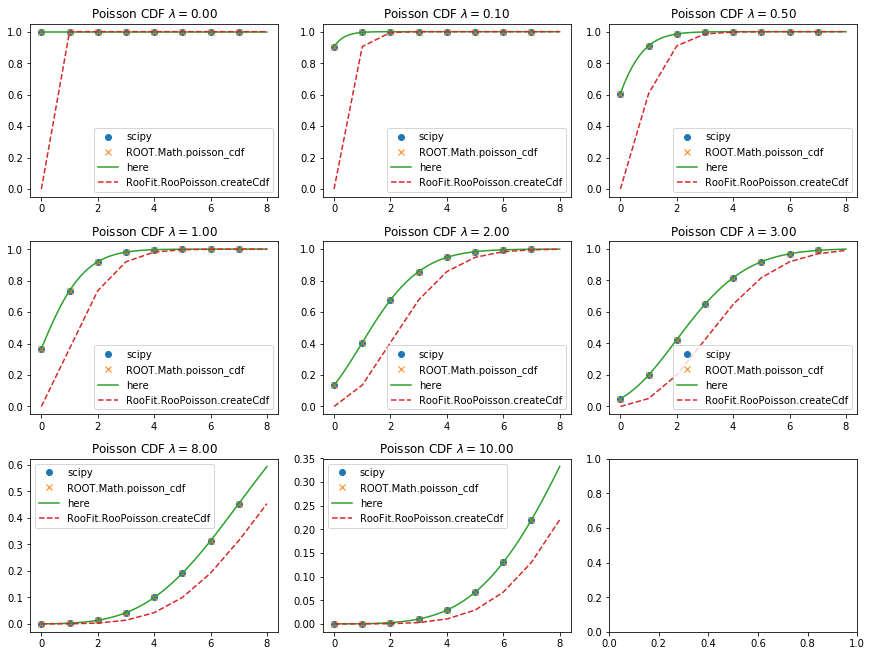

In [6]:
NEXAMPLES = (0, 0.1, 0.5, 1, 2, 3, 8, 10)
fig, axs = plt.subplots(int(len(NEXAMPLES) / 3) + 1, 3, figsize=(12, 9), constrained_layout=True)
xspace = np.linspace(0, 8, 200)
xspace_int = np.arange(0, 8)

for nexample, ax in zip(NEXAMPLES, axs.flat):
    xvar = ROOT.RooRealVar('xvar', 'xvar', -10, 100)
    root_poisson = ROOT.RooPoisson('roopoisson', 'roopoisson', xvar, ROOT.RooFit.RooConst(nexample))
    root_poisson_cdf = root_poisson.createCdf(ROOT.RooArgSet(xvar))
    root_poisson_cdf_f = root_poisson_cdf.asTF(ROOT.RooArgList(xvar))

    ax.plot(np.arange(0, 8), stats.poisson(nexample).cdf(np.arange(0, 8)), 'o', label='scipy')
    ax.plot(xspace_int, [ROOT.Math.poisson_cdf(int(x), nexample) for x in xspace_int], 'x', label='ROOT.Math.poisson_cdf')    
    ax.plot(xspace, poisson_cdf(nexample, xspace), label='here')
    ax.plot(xspace, [root_poisson_cdf_f.Eval(x) for x in xspace], '--', label='RooFit.RooPoisson.createCdf')
    ax.legend(loc=0)
    ax.set_title("Poisson CDF $\lambda = %.2f$" % nexample)
fig.savefig('poisson_cdf.png', bbox_inches='tight')

In [7]:
examples = (1, 4, 4.1, 0.2, 0.1, 0, 100.)


def compute_pvalue2(nobs, ntrue, left):
    if left:
        # the left case (<=) is the cdf
        return poisson_cdf(ntrue, nobs)
    else:
        return 1 - poisson_cdf(ntrue, nobs - 1)  # is this -1 correct ??

    
for example in examples:    
    print(compute_pvalue(1, example, False))
    print(compute_pvalue2(1, example, False))
    print()

0.6321205588285577
0.6321205588285577

0.9816843611112659
0.9816843611112658

0.9834273245982388
0.9834273245982388

0.18126924692201815
0.18126924692201818

0.09516258196404045
0.09516258196404048

0.0
0.0

1.0
1.0



In [8]:
def scale_range(start, start1, start2, end1, end2):
    m = (end2 - end1) / float(start2 - start1)
    return end1 + m * (start - start1)


def compute_poisson_error(n):
    a = ROOT.Double()
    b = ROOT.Double()
    if abs(n - np.round(n)) < 1E-5:
        ROOT.RooHistError.instance().getPoissonInterval(int(np.round(n)), a, b)
        return n - float(a), float(b) - n
    else:
        yfloor = np.floor(n).astype(int)
        yceil = yfloor + 1

        ROOT.RooHistError.instance().getPoissonInterval(int(yfloor), a, b)
        floor_error = n - a, b - n
        ROOT.RooHistError.instance().getPoissonInterval(int(yceil), a, b)
        ceil_error = n - a, b - n

        lo = scale_range(n, yfloor, yceil, floor_error[0], ceil_error[0])
        hi = scale_range(n, yfloor, yceil, floor_error[1], ceil_error[1])

        return lo, hi

    
def compute_poisson_error2(n):    
    nup = brenth(lambda x: compute_pvalue2(n, x, True) - ALPHA / 2., n, n * 10 + 10)
    ndown = brenth(lambda x: compute_pvalue2(n, x, False) - ALPHA / 2., 0, n)
    
    return n - ndown, nup - n


def compute_poisson_error3(n):
    return n - stats.gamma.isf(1 - ALPHA / 2., n) if n != 0 else 0., stats.gamma.isf(ALPHA / 2., n + 1) - n


for example in examples:
    print("\nconfidence level for observed = %s" % example)
    print(compute_poisson_error(example))
    print(compute_poisson_error2(example))
    print(compute_poisson_error3(example))


confidence level for observed = 1
(0.8272462209765501, 2.299526559115855)
(0.8272462209764571, 2.2995265591158547)
(0.8272462209765501, 2.299526559115855)

confidence level for observed = 4
(1.914339186222883, 3.1627531722609437)
(1.914339186222883, 3.162753172260784)
(1.914339186222883, 3.1627531722609437)

confidence level for observed = 4.1
(1.9388743820412726, 3.184725120249538)
(1.9402664910023666, 3.1857143247715154)
(1.9402664910023666, 3.1857143247715145)

confidence level for observed = 0.2
(0.16544924419531004, 1.3782048833826255)
(0.19993439928800424, 1.9492740767387773)
(0.19993439928800444, 1.9492740767387804)

confidence level for observed = 0.1
(0.08272462209765502, 1.263039673915972)
(0.09999999386302454, 1.8966256126504266)
(0.09999999386306778, 1.8966256126504326)

confidence level for observed = 0
(0.0, 1.1478744644493182)
(0.0, 1.8410216450092636)
(0.0, 1.8410216450092634)

confidence level for observed = 100.0
(9.983254822886579, 11.033360941149681)
(9.98325482288

## Weighted case

We have a procedure to find the error bars, but it assumes that the quantity in each bin is distributed as a Poissonian random variable. This is not true when summing categories with weights. For a category $i$ the number of events (consider just one bin) is distributed as a Poisson:

$$N_i \sim \text{Pois}(\lambda_i)$$

where $\lambda_i$ is the true number of events in category-$i$. Now we are weighing them to get:

$$N_w = \sum w_i N_i$$

Our obseved data are $\{n_{obs}^{(i)}\}_i$ and we define $n_{obs,w} = \sum w_i n_{obs}^{(i)}$.

The question is how the random variable $N_w$ is distributed, then we can use the RooFit procedure explained above.

The weighted sum of poisson random variable $N_w$ is *approximatively* distributed as a scaled-poisson.

The expected value and the variance of $N_w$ are

$$\lambda = E[N_w] = \sum_i w_i E[N_i] = \sum_i w_i \lambda_i$$
 
$$V[N_w] = \sum_i w_i^2 V(N_i) = \sum_i w_i^2 \lambda_i$$

The fact that $E[N_w] \neq V[N_w]$ proves that $N_w$ is not poisson-distributed.

Let approximate them value with the observed values:

$$\lambda = E[N_w] \simeq \sum_i w_i n_\text{obs}^{(i)} = n_{\text{obs}, w}\\
  V[N_w] \simeq \sum_i w_i^2 n_\text{obs}^{(i)}$$


A new random variable $N_w'$ is defined as a poisson random variable
forcing it to have the same ratio standard deviation / expected values as $N_w$:

$$\frac{\sqrt{V[N_w]}}{E[N_w]} = \frac{\sqrt{V[N_w']}}{E[N_w']}$$

and of course 

$$E[N_w'] = V[N_w']$$

since $N_w'$ is poissonian. The only parameter we need to find to know the distribution is $E[N_w']$. Solving the system of the previous two equations:

$$\tilde\lambda = E[N_w'] = \frac{\left(\sum_i w_i n_{obs}^{(i)}\right)^ 2}{\sum_i w_i^2 n_{obs}^{(i)}}$$

We now know $N_w'\sim\text{Poisson}(E[N_w'])$

Define $N_w$ to be $N_w'$ rescaled to the correct expected value ($E[N_w] = n_{obs, w} = \sum_i w_i
\lambda_i \simeq \sum_i w_i n_{obs}^{(i)} = n_{obs, w}$):

$$N_w = N_w' \times c = N_w' \times\frac{E[N_w]}{E[N_w']} =  N_w' \times  \frac{\sum_i w_i^2 n_{obs}^{(i)}}{\sum_i w_i n_{obs}^{(i)}}$$

Note that since the expected value and the standard deviation are homogenous then the ratio we have imposed in unchanged when multiplying by $c$.

Then the distribution of $N_w$ is a scaled-Poisson distribution with pdf:

$$\text{Scaled-Poisson}(n|c, \tilde\lambda) = \text{Pois}\left(\left.\frac{n}{c} \right| \tilde\lambda\right)$$

(technically a poisson distribution is defined only for integer arguments, here $n/c$, so by Poisson we mean the extension to real numbers using Euler's Gamma-function instead of the factorial)

## How to compute error bars

We can use the procedure described at the begin to find the error bar, or, practically more convenient:

 * compute the 68% cofidence interval of $N_w'$ (which is Poisson distributed) with `RooHistError::getPoissonInterval` (using $\tilde\lambda$, with some tricks since it is not integer)
 * multiply this interval by the factor c to get the confidence interval for $N_w$

## Special cases

### Just one category (or when one category dominates)

$$\tilde\lambda = \frac{\left(\sum_i w_i n_{obs}^{(i)}\right)^ 2}{\sum_i w_i^2 n_{obs}^{(i)}} = \frac{\left(w_1 n_{obs}^{(1)}\right)^2}{w_1^2 n_{obs}^{(1)}} = n_{obs}^{(1)}$$

$$c =  \frac{\sum_i w_i^2 n_{obs}^{(i)}}{\sum_i w_i n_{obs}^{(i)}} = \frac{w_1^2 n_{obs}^{(1)}}{w_1 n_{obs}^{(1)}} = w_1$$

So the error on $w_1 n_{obs}^{(1)}$ will be simply the Poisson error assuming $n_{obs}^{(1)}$ multiplied by $w_1$, as expected

### Categories with the same weights

$$\tilde\lambda = \frac{\left(\sum_i w_i n_{obs}^{(i)}\right)^ 2}{\sum_i w_i^2 n_{obs}^{(i)}} =
\frac{\left(\sum_i w n_{obs}^{(i)}\right)^ 2}{\sum_i w^2 n_{obs}^{(i)}} = \frac{\left(\sum_i n_{obs}^{(i)}\right)^ 2}{\sum_i n_{obs}^{(i)}} = \sum_i n_{obs}^{(i)}$$

$$c =  \frac{\sum_i w_i^2 n_{obs}^{(i)}}{\sum_i w_i n_{obs}^{(i)}} = w$$

So the error will be simply the Poisson error assuming $\sum_i n_{obs}^{(i)}$ (in fact the sum of Poissons is a Poisson) multiplied by $w$, as expected

In [9]:
def compute_scaled_poisson_errorbar(nevents, weights):
    """
    nevents = list of number of evets for each category
    weights = list of weights for each category
    return central value, error down (negative), error up
    """
    nevents = np.asarray(nevents)
    weights = np.asarray(weights)
    
    nw = float(np.sum(nevents * weights, axis=0))
    nw2 = float(np.sum(nevents * weights ** 2, axis=0))
    lambda_tilde = nw ** 2 / nw2
    scale = nw2 / nw
        
    e = compute_poisson_error(lambda_tilde)
    return nw, -e[0] * scale, e[1] * scale

In [10]:
def compute_scaled_poisson_errorbar2(nevents, weights):
    """
    nevents = list of number of evets for each category
    weights = list of weights for each category
    return central value, error down (negative), error up
    """
    """
    nevents = list of number of evets for each category
    weights = list of weights for each category
    return central value, error down (negative), error up
    """
    nevents = np.asarray(nevents)
    weights = np.asarray(weights)
    
    nw = float(np.sum(nevents * weights, axis=0))
    nw2 = float(np.sum(nevents * weights ** 2, axis=0))
    lambda_tilde = nw ** 2 / nw2
    scale = nw2 / nw
        
    e = compute_poisson_error2(lambda_tilde)
    return nw, -e[0] * scale, e[1] * scale

In [11]:
def compute_scaled_poisson_errorbar3(nevents, weights):
    """
    nevents = list of number of evets for each category
    weights = list of weights for each category
    return central value, error down (negative), error up
    """
    """
    nevents = list of number of evets for each category
    weights = list of weights for each category
    return central value, error down (negative), error up
    """
    nevents = np.asarray(nevents)
    weights = np.asarray(weights)
    
    nw = float(np.sum(nevents * weights, axis=0))
    nw2 = float(np.sum(nevents * weights ** 2, axis=0))
    lambda_tilde = nw ** 2 / nw2
    scale = nw2 / nw
        
    e = compute_poisson_error3(lambda_tilde)
    return nw, -e[0] * scale, e[1] * scale

In [12]:
def scaled_poisson_pdf(x, l, c):
        x = x / c
        return np.exp(x * np.log(l) - l - gammaln(x + 1))

In [100]:
def compute_scaled_poisson_toys(nevents, weights, ntoys=10000):
    nevents = np.asarray(nevents)
    weights = np.asarray(weights, dtype=float)
    nw_obs = np.sum(nevents * weights)
    
    def compute_pvalue(mu, upper=True):
        test_true_n = nevents * mu
        test_nw = nw_obs * mu

        toys_ns = stats.poisson(test_true_n).rvs(size=(ntoys, len(weights)))
        toys_nw = np.sum(toys_ns * weights, axis=1)
        if upper:
            pvalue = (toys_nw < nw_obs).sum() / float(ntoys)
        else:
            pvalue = (toys_nw > nw_obs).sum() / float(ntoys)
        return pvalue
    
    return nw_obs, brenth(lambda x: compute_pvalue(x, False) - ALPHA / 2., 1E-4, 1.1) * nw_obs - nw_obs, \
              brenth(lambda x: compute_pvalue(x, True) - ALPHA / 2., 0.9, 10) * nw_obs - nw_obs
            

In [13]:
def compute_scaled_poisson_bruteforce(nevents, weights):
    nevents = np.asarray(nevents)
    weights = np.asarray(weights)

    w_obs = np.sum(nevents * weights)

    ntests = 1000
    test_ns = stats.norm(nevents, np.sqrt(nevents)).rvs((ntests, len(nevents)))
    test_ns = np.clip(test_ns, 0, np.inf)

    test_nw = np.sum(test_ns * weights, axis=1)
    test_nw2 = np.sum(test_ns * weights ** 2, axis=1)
    test_lambda_tilde = test_nw ** 2 / test_nw2
    test_scale = test_nw2 / test_nw

    pvalues = [quad(lambda x: scaled_poisson_pdf(x, l, s), w_obs, np.inf)[0] for l, s in zip(test_lambda_tilde, test_scale)]
    closer = np.argmin(np.abs(pvalues - ALPHA / 2))
    limit_down = test_nw[closer]

    pvalues = [quad(lambda x: scaled_poisson_pdf(x, l, s), 0, w_obs)[0] for l, s in zip(test_lambda_tilde, test_scale)]
    closer = np.argmin(np.abs(pvalues - ALPHA / 2))
    limit_up = test_nw[closer]

    return w_obs, limit_down - w_obs, limit_up - w_obs

In [14]:
def linear_propagation(nevents, weights):
    nevents = np.asarray(nevents)
    weights = np.asarray(weights)
    
    nw = float(np.sum(nevents * weights, axis=0))
    nw2 = float(np.sum(nevents * weights ** 2, axis=0))

    linear_error = np.sqrt(nw2)
    return nw, -linear_error, linear_error

In [108]:
functions = [compute_scaled_poisson_errorbar, compute_scaled_poisson_errorbar2, compute_scaled_poisson_errorbar3,
            compute_scaled_poisson_bruteforce, compute_scaled_poisson_toys, linear_propagation]

n = [10000, 20, 30]; w = [1, 0, 0]
for f in functions:
    print("%40s: %s" % (f.__name__, f(n, w)))
print()
n = [100, 20, 30]; w = [1, 0, 0]
for f in functions:
    print("%40s: %s" % (f.__name__, f(n, w)))
print()
n = [100, 20, 30]; w = [1.2, 0.1, 0]
for f in functions:
    print("%40s: %s" % (f.__name__, f(n, w)))
print()
n = [100, 20, 0]; w = [1.2, 0.1, 0]
for f in functions:
    print("%40s: %s" % (f.__name__, f(n, w)))
print()
n = [100, 20]; w = [1.2, 0.1]
for f in functions:
    print("%40s: %s" % (f.__name__, f(n, w)))
print()
w = np.array([1.39, 0.55, 0.27, 1.53, 0.55, 0.23, 0.03])
n = np.array([0.6, 0.3, 0.4, 0.3, 2, 2, 5])
for f in functions:
    print("%40s: %s" % (f.__name__, f(n, w)))


         compute_scaled_poisson_errorbar: (10000.0, -99.50124999218679, 100.50124999218679)
        compute_scaled_poisson_errorbar2: (10000.0, -99.99833258825674, 101.00333402802971)
        compute_scaled_poisson_errorbar3: (10000.0, -99.99833258825674, 101.00333402802971)
       compute_scaled_poisson_bruteforce: (10000, -99.6687257648864, 101.11331090386193)
             compute_scaled_poisson_toys: (10000.0, -98.27393603059318, 99.45944401148517)
                      linear_propagation: (10000.0, -100.0, 100.0)

         compute_scaled_poisson_errorbar: (100.0, -9.983254822886579, 11.033360941149681)
        compute_scaled_poisson_errorbar2: (100.0, -9.983254822886593, 11.033360941149908)
        compute_scaled_poisson_errorbar3: (100.0, -9.983254822886593, 11.033360941149667)
       compute_scaled_poisson_bruteforce: (100, -9.524215516470534, 10.547125777594715)
             compute_scaled_poisson_toys: (100.0, -8.94813091416124, 9.811634596545133)
                      linear_p

## Example showing the distribution from toys
Suppose we have three categories, weighted with some weights

In [109]:
weights = np.array([1.39, 0.55, 0.27, 1.53, 0.55, 0.23, 0.13])
NEVENTS_PER_CAT = np.array([0.1, 0.1, 0.1, 0.1, 2, 5, 22])
NCAT = len(NEVENTS_PER_CAT) # numbers of categories
NTOYS = 100000

print("weights: \t\t", weights)
print("nevent per cat (true)\t", NEVENTS_PER_CAT)
print("wsum (true)\t\t", np.sum(NEVENTS_PER_CAT * weights))

weights: 		 [1.39 0.55 0.27 1.53 0.55 0.23 0.13]
nevent per cat (true)	 [ 0.1  0.1  0.1  0.1  2.   5.  22. ]
wsum (true)		 5.484000000000001


In [113]:
from tqdm import tnrange, tqdm_notebook

def toy_study(nevents_per_cat, weights, ntoys=1000, algorithms=(compute_scaled_poisson_errorbar3, )):

    true_w = np.sum(nevents_per_cat * weights)

    results = {}
    for algorithm in algorithms:
        results[algorithm.__name__] = {'reco': [], 'up': [], 'down': []}

    for itoy in tnrange(ntoys):
        n = [np.random.poisson(n) for n in nevents_per_cat]
        
        for algorithm in algorithms:
    
            b, down, up = algorithm(n, weights)
            results[algorithm.__name__]['reco'].append(b)
            results[algorithm.__name__]['up'].append(up)
            results[algorithm.__name__]['down'].append(-down)
            
    for algorithm in algorithms:
        results[algorithm.__name__] = {k: np.array(v) for k, v in results[algorithm.__name__].items()}

        
    return results
    
    
toys_result = toy_study(NEVENTS_PER_CAT, weights, 1000, [compute_scaled_poisson_errorbar3, linear_propagation, compute_scaled_poisson_toys])    

In [115]:
def analyze_toys(toys, true_w):
    ntoys = len(toys['reco'])
    covered = (toys['reco'] - toys['down'] < true_w) & (true_w < toys['reco'] + toys['up'])
    coverage = np.mean(covered)
    error_coverage = np.sqrt(coverage * (1 - coverage) / ntoys)
    print("coverage %s %% +/- %s %% " % (coverage * 100, error_coverage * 100))
       
    diff = toys['reco'] - true_w
    up_down = np.where(diff < 0, toys['up'], toys['down'])
    pulls = diff / up_down
    print("mean pulls", np.mean(pulls), stats.sem(pulls))
    print("std pulls", np.std(pulls))

    
analyze_toys(toys_result[compute_scaled_poisson_errorbar3.__name__], np.sum(NEVENTS_PER_CAT * weights)) 
print("=" * 80)
analyze_toys(toys_result[linear_propagation.__name__], np.sum(NEVENTS_PER_CAT * weights)) 
print("=" * 80)
analyze_toys(toys_result[compute_scaled_poisson_toys.__name__], np.sum(NEVENTS_PER_CAT * weights)) 

coverage 73.4 % +/- 1.3972973913952607 % 
mean pulls -0.14043396403578395 0.03164643625751294
std pulls 1.0002476847626436
coverage 68.7 % +/- 1.4663935351739654 % 
mean pulls -0.2574819234436853 0.03671697427349551
std pulls 1.1605119833938513
coverage 68.0 % +/- 1.475127113166862 % 
mean pulls -0.1644513856774685 0.03577478831506069
std pulls 1.1307323483072442


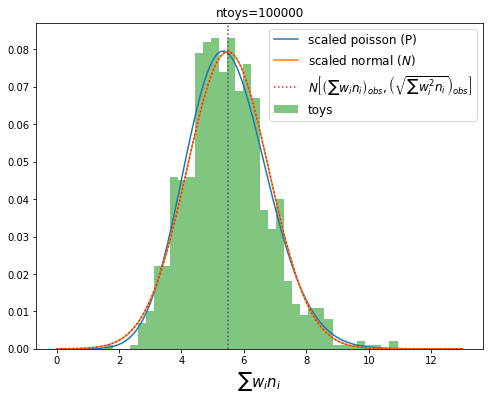

In [116]:
def plot_toys(nevents_per_cat, weights, toys):
    fig, ax = plt.subplots(figsize=(8, 6))
    NBINS = 50
    XMAX = 13.
    wh = np.ones_like(toys) / float(len(toys))
    
    nw = (nevents_per_cat * weights).sum()
    nw2 = (nevents_per_cat * weights ** 2).sum()
    lambda_tilde = nw ** 2 / nw2
    scale = nw2 / nw
    true_w = np.sum(nevents_per_cat * weights)
   

    from scipy import integrate
    n = integrate.quad(lambda x: scaled_poisson_pdf(x, lambda_tilde, scale), 0, XMAX)[0]
    xs = np.linspace(0, XMAX, 100)
    ax.plot(xs, scaled_poisson_pdf(xs, lambda_tilde, scale) / (NBINS / XMAX) / n, label='scaled poisson (P)')
    ax.plot(xs, stats.norm(true_w/scale, np.sqrt(lambda_tilde)).pdf(xs / scale) / (NBINS / XMAX) / scale, label=r'scaled normal $(N)$')
    ax.hist(toys, bins=np.linspace(0, XMAX, NBINS + 1), weights=wh, label='toys', alpha=0.6)

    ax.plot(xs, stats.norm(true_w, np.sqrt(nw2)).pdf(xs) / (NBINS / XMAX), ':', label=r'$N\left[\left(\sum w_i n_i \right)_{obs}, \left(\sqrt{\sum w_i^2 n_i}\right)_{obs}\right]$')
    ax.set_title("#toys ")

    ax.legend(loc=0, fontsize=12)
    ax.set_title(u'ntoys=%d' % NTOYS)
    ax.axvline(nw, ls=":", color="0.3")

    ax.set_xlabel('$\sum w_i n_i$', fontsize=15)

    return fig

plot_toys(NEVENTS_PER_CAT, weights, list(toys_result.values())[0]['reco'])
plt.show()

/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  app.launch_new_instance()
/home/turra/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.



compute_scaled_poisson_errorbar3
coverage 70.0 % +/- 10.2469507659596 % 
mean pulls 0.012018868250213397 0.22560465130808882
std pulls 0.9833878762446905

linear_propagation
coverage 60.0 % +/- 10.954451150103322 % 
mean pulls -0.2477220128032776 0.3195532697040312
std pulls 1.3929004097178699

compute_scaled_poisson_bruteforce
coverage 35.0 % +/- 10.66536450385077 % 
mean pulls -0.08614233837817888 0.6434396137592875
std pulls 2.8046882526475776


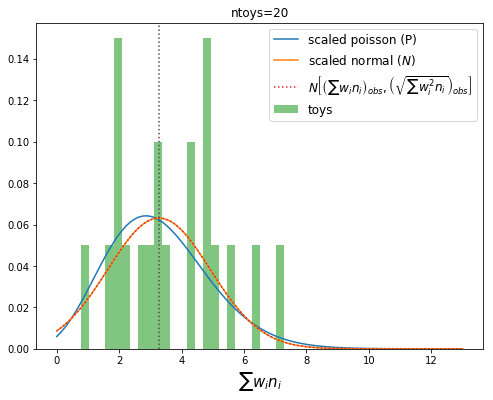

In [150]:
weights = np.array([1.39, 0.55, 0.27, 1.53, 0.55, 0.23, 0.03])
NEVENTS_PER_CAT = np.array([0.6, 0.3, 0.4, 0.3, 2, 2, 5])
NCAT = len(NEVENTS_PER_CAT) # numbers of categories
NTOYS = 20

algorithms = [compute_scaled_poisson_errorbar3, linear_propagation, compute_scaled_poisson_bruteforce]

toys_result = toy_study(NEVENTS_PER_CAT, weights, NTOYS, algorithms)    

for algorithm in algorithms:
    print('\n' + algorithm.__name__)
    analyze_toys(toys_result[algorithm.__name__], np.sum(NEVENTS_PER_CAT * weights)) 


plot_toys(NEVENTS_PER_CAT, weights, list(toys_result.values())[0]['reco'])
plt.show()

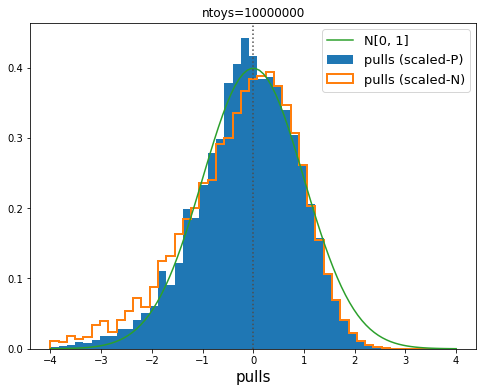

In [139]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(data_pulls, bins=np.linspace(-4, 4, 50), normed=True, label='pulls (scaled-P)')
ax.hist(data_pulls_linear, bins=np.linspace(-4, 4, 50), normed=True, label='pulls (scaled-N)', histtype='step', lw=2)

xs = np.linspace(-4, 4, 100)
ax.plot(xs, stats.norm(0, 1).pdf(xs), label='N[0, 1]')
ax.axvline(0, ls=':', color='0.3')
ax.set_title(u'ntoys=%d' % NTOYS)
ax.legend(loc=0, fontsize=13)
ax.set_xlabel('pulls', fontsize=15)
plt.show()
fig.savefig('pulls.png', bbox_inches='tight')
fig.savefig('pulls.pdf', bbox_inches='tight')

In [26]:
print compute_scaled_poisson_errorbar([100, 20, 30], [10, 0, 0])
print compute_scaled_poisson_errorbar2([100, 20, 30], [10, 0, 0])

(1000.0, -99.83254822886579, 110.33360941149681)
(1000.0, -99.83254822886593, 110.33360941149667)


In [27]:
print compute_scaled_poisson_errorbar([100, 20, 30], [10, 2., 1.])
print compute_scaled_poisson_errorbar2([100, 20, 30], [10, 2., 1.])

(1070.0, -95.93494182302038, 105.3835399538615)
(1070.0, -100.39986130246784, 110.29331113626702)


In [17]:
(1 - ALPHA * 2)

0.6826894921370859

In [18]:
(1 - 0.6826894921370859) / 2.

0.15865525393145707

In [143]:
ALPHA

0.15865525393145707